# Assignment 5: Continous-time models
## [Scientific Computing with Python](https://scicompy.yoavram.com/)

In [1]:
from datetime import datetime

%matplotlib inline
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context('talk')
red, blue, green = sns.color_palette('Set1', 3)

import scipy.stats
import scipy.optimize
from scipy.integrate import solve_ivp
from functools import partial

import warnings
warnings.filterwarnings('ignore')

# General instructions

1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. This exercise doesn't put much emphasis on efficieny or runtime. *But*, your code should still run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, wherever possible to "lose your loops".
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment 5"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

# Ex 1: Generalized logistic model

Here is the growth curve data that we saw in the lecture: the density of a bacterial culture in 94 samples across time.

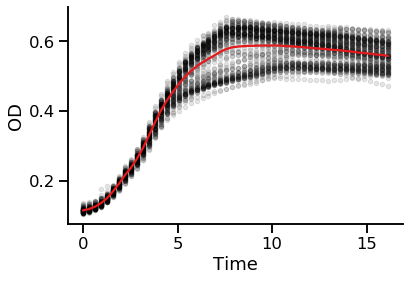

In [2]:
###
data = np.load('../data/Yoav_311214c_only_OD.npz')
t, N, t_agg, N_agg = data['t'], data['N'], data['t_agg'], data['N_agg']

plt.plot(t, N, '.k', alpha=0.1)
plt.plot(t_agg, N_agg, '-', color=red)
plt.xlabel('Time')
plt.ylabel('OD')
sns.despine();

The [generalized logistic model](https://en.wikipedia.org/wiki/Generalised_logistic_function) has an additional parameter $\nu$ so that the curve doesn't have to be symmetric, that is, the time to get from $N(0)$ to $K/2$ can be longer/shorter than the time to get from $K/2$ to $K$.

$$
\frac{d N}{d t}= r N \bigg(1 - \bigg(\frac{N}{K}\bigg)^{\nu}\bigg)
$$

The other parameters are the same as the logistic model.

**Fit the logistic and the generalized logistic model to the data** and print the model parameters with their confidence intervals (i.e. estimated standard deviations).

<b>Additinal/Unrelated work:</b>

$
\frac{d N}{d t} = r N \bigg(1 - \big(\frac{N}{K}\big)^{\nu}\bigg)  \\
\space\space\space\space\space \Downarrow \\
\frac{d N}{ N \bigg(1 - \big(\frac{N}{K}\big)^{\nu}\bigg) } = r d t \\
{\Large\int} \frac{d N}{ N \big(1 - \big(\frac{N}{K}\big)^{\nu}\big) } = {\Large\int} r d t \\
\ln(N) - \frac{1}{\nu} \ln\bigg(1-\big(\frac{N}{k}\big)^\nu\bigg) = rt \pm C \\
\ln(N^\nu) - \ln\bigg(1-\big(\frac{N}{k}\big)^\nu\bigg) = \nu rt \pm \nu C \\
\ln \bigg( \frac{N^\nu}{1-\big(\frac{N}{k}\big)^\nu} \bigg) = \nu rt \pm \nu C \\
\frac{N^\nu}{1-\big(\frac{N}{k}\big)^\nu} = e^{\nu rt \pm \nu C} \\
\frac{N^\nu}{\frac{k^\nu-N^\nu}{k^\nu}} = e^{\nu rt \pm \nu C} \\ 
\frac{N^\nu}{\frac{k^\nu-N^\nu}{k^\nu}} = e^{\nu rt \pm \nu C} \\ 
\frac{k^\nu N^\nu}{k^\nu-N^\nu} = e^{\nu rt \pm \nu C} \\
\frac{N^\nu}{k^\nu-N^\nu} = k^{-\nu} e^{\nu rt \pm \nu C} \\
\frac{k^\nu-N^\nu}{N^\nu} = k^{\nu} e^{-\nu rt \mp \nu C} \\
\frac{k^\nu}{N^\nu} -1 = k^{\nu} e^{-\nu rt \mp \nu C} \\
\frac{k^\nu}{N^\nu} = 1 + k^{\nu} e^{-\nu rt \mp \nu C} \\
\frac{k^\nu}{N^\nu} = 1 + k^{\nu} e^{-\nu rt} e^{ \mp \nu C} \\
\frac{k^\nu}{N^\nu} = 1 + \frac{k^{\nu}}{e^{ \pm \nu C}} e^{-\nu rt} \\
\frac{k^\nu}{N^\nu} = 1 + (\frac{k}{e^{ \pm C}})^\nu e^{-\nu rt} \\
\frac{k}{N} = \sqrt[\nu]{1 + (\frac{k}{e^{ \pm C}})^\nu e^{-\nu rt} } \\
N = \frac{k}{\sqrt[\nu]{1 + (\frac{k}{e^{ \pm C}})^\nu e^{-\nu rt} }}\\
\space\space\space\space\space\Downarrow \\
N(t) = \frac{k}{\sqrt[\nu]{1 + (\frac{k}{N(0)})^\nu e^{-\nu rt} }}\\
$

I guessed I got it wrong somewhere... and I don't know where I did wrog cuz by this <a href='https://en.wikipedia.org/wiki/Generalised_logistic_function#Generalised_logistic_differential_equation'>link</a> in wiki it's:
$$N(t) = \frac{k}{\sqrt[\nu]{1 + \bigg(-1 + \big(\frac{K}{N(0)}\big)^\nu \bigg) e^{-\nu rt} }}$$


In [3]:
def logistic(t, N0, K, r): ###
    return K / (1 - (1 - K/N0) * np.exp(-r * t))    

def generalized_logistic(t, N0, K, r, ν):
    return K / (1 + (-1 + (K/N0)**ν ) * np.exp(-ν * r * t))**(1/ν)

std_estimated = 1.1
v_estimated = 3.1

params_logistic,pcov_logistic = scipy.optimize.curve_fit(logistic,t,N,(N.min(),N.max(),std_estimated)) 
params_generalized_logistic,pcov_generalized_logistic = scipy.optimize.curve_fit(generalized_logistic,t,N,(N.min(),N.max(),std_estimated,v_estimated))

# confidence intervals:
errors_logistic = np.sqrt(np.diag(pcov_logistic))
errors_generalized_logistic = np.sqrt(np.diag(pcov_generalized_logistic))

# print
print('Logistic:')
print('N0 = ',params_logistic[0],'\u00B1',errors_logistic[0])
print('K  = ',params_logistic[1],'\u00B1',errors_logistic[1])
print('r  = ',params_logistic[2],'\u00B1',errors_logistic[2])

print('Generalized Logistic:')
print('N0 = ',params_generalized_logistic[0],'\u00B1',errors_generalized_logistic[0])
print('K  = ',params_generalized_logistic[1],'\u00B1',errors_generalized_logistic[1])
print('r  = ',params_generalized_logistic[2],'\u00B1',errors_generalized_logistic[2])

# Result:
# N0 = 0.100 +- 0.00167241
# K  = 0.579 +- 0.00081591
# r  = 0.357 +- 0.00757670
# ν  = 3.253 +- 0.18051848


Logistic:
N0 =  0.07274651832114666 ± 0.0012482881755787746
K  =  0.5845190372292338 ± 0.0008750376475394406
r  =  0.6700808151465685 ± 0.006143664477166752
Generalized Logistic:
N0 =  0.10010534820691291 ± 0.0016723969521440923
K  =  0.5787867720712359 ± 0.0008159014946325284
r  =  0.3565795063033188 ± 0.007576418649366046


**Plot the fitted curves together with the data.**

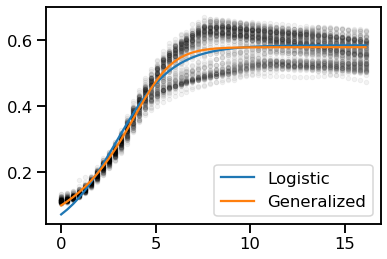

In [4]:
N_logistic = logistic(t_agg,*params_logistic) # using unpacking 
N_generalized_logistic = generalized_logistic(t_agg, *params_generalized_logistic)

plt.plot(t, N, '.k', alpha=0.05)
plt.plot(t_agg,N_logistic,label='Logistic')
plt.plot(t_agg,N_generalized_logistic,label='Generalized')
plt.legend()
plt.show()

 Which is a better fit? The logistic model or the generalized logistic?

These models are nested: the logistic model is equivalent to the generalized model with $\nu=1$. 

Therefore, we can use the likelihood ratio test (or a regerssion [F-test](https://en.wikipedia.org/wiki/F-test#Regression_problems)) to select between them.

We check if the evidence (data) supports rejecting the null model (logisitc model) in favor of the alternative model (generalized logistic model) despite the additional parameter ($\nu$) of the alternative model.

**Implement the likelihood ratio test** and print the result.

In [5]:
N_hat_logistic = logistic(t,*params_logistic)
N_hat_generalized_logistic = generalized_logistic(t,*params_generalized_logistic)

n = len(t)                # data points number
p0 = 3                    # parameters in logistic (null model)
p1 = 4                    # parameters in generalized_logistic (alternative model)

rss0 = np.sum( (N - N_hat_logistic)**2 )
rss1 = np.sum( (N - N_hat_generalized_logistic)**2 )

F = ((rss0 - rss1) / (p1 - p0)) / (rss1 / (n - p1))  
pvalue = scipy.stats.f(p1 -p0, n - p1).sf(F)         # sf = 1-cdf

print("F-statistic: {:.2f}".format(F)) ###
print("Likelihood-ratio test P-value = {}".format(pvalue)) ###
print("Generalized logistic model is favored?", pvalue < 0.05) ###

F-statistic: 446.68
Likelihood-ratio test P-value = 6.058805890524659e-95
Generalized logistic model is favored? True


<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

# Ex 2: Fit Lotka-Volterra competition models to experimental data

In this section we will analyse competitions between two strains of bacteria.

Let's start by loading some data.

## Data

You might need to do a `git pull` to get the data.

In [6]:
###
df = pd.read_csv('../data/flow_df_2015-11-18.csv')
df = df[['Strain','date','hour','freq_mean']]
df = df.rename(columns=dict(Strain='strain', freq_mean='frequency'))
df.head()

,strain,date,hour,frequency
0,Green,11/18/2015,10:30,0.432883
1,Red,11/18/2015,10:30,0.567117
2,Green,11/18/2015,11:25,0.386035
3,Red,11/18/2015,11:25,0.613965
4,Green,11/18/2015,12:10,0.337225


The data shows results of competitions between two bacteria strains, one marked as _Green_ and the other as _Red_.  
Approximately every hour, a sample was taken from the tube in which the bacteria were competing.  
The sample was then processed using flow cytometry to count the number of cells with either a green or a red fluorescent protein (GFP or RFP). Then, the frequencies of the green and red cells were calculated by dividing the number of cells by the total number of cells (i.e. frequency of green = number of green / (number of green + number of red)).

The frequency of each strain was recored at each time point, but times are encoded as dates and hours.

**Create a new column called `time`** that has the number of hours passed since the start of the experiment.
Then you can drop the `date` and `hour` columns.

Tips: you can use `datetime.strptime`.

In [7]:
df['Hour'] = pd.to_datetime(df['hour'], format='%H:%M')
df['time'] = df['Hour'] - df['Hour'][0]
df['time'] = df['time'].apply(lambda d: d.seconds/3600)

df = df.drop(['date','hour','Hour'], 1)
df

,strain,frequency,time
0,Green,0.432883,0.000000
1,Red,0.567117,0.000000
2,Green,0.386035,0.916667
3,Red,0.613965,0.916667
4,Green,0.337225,1.666667
5,Red,0.662775,1.666667
6,Green,0.222792,2.750000
7,Red,0.777208,2.750000
8,Green,0.178563,3.666667
9,Red,0.821437,3.666667


**Plot the frequencies of the two strains over time**.
Make sure you use the correct colors, labels, etc.

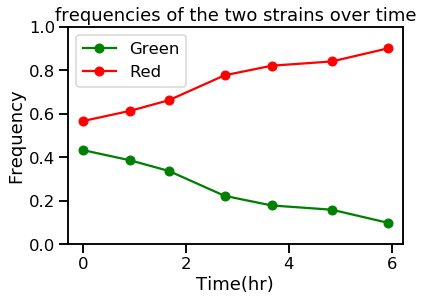

In [9]:
fig, ax = plt.subplots()

grouped = df.groupby('strain')
for key,group in grouped:
    group.plot(ax=ax, kind='line', x='time', y='frequency',marker='o', label=key, color=key)

plt.title('frequencies of the two strains over time')
plt.xlabel('Time(hr)')
plt.ylabel('Frequency')
plt.ylim((0,1))
plt.legend()
plt.show()


To model competitions between two strains (or species) we will use the classical [competitive Lotka–Volterra equations](https://en.wikipedia.org/wiki/Competitive_Lotka–Volterra_equations) (not to be confused with the predator-prey Lotka-Volterra equations).

This model describes the change in the population sizes of the two strains, $x_1$ and $x_2$.

$$
\frac{dx_1}{dt} = r_1 x_1 \Big(1 - \bigg(\frac{x_1 + \alpha_2 x_2}{K_1}\bigg)\Big) \\
\frac{dx_2}{dt} = r_2 x_2 \Big(1 - \bigg(\frac{\alpha_1 x_1 + x_2}{K_2}\bigg)\Big)
$$

where $r_i$ and $K_i$ are the per-capita growth rate and maximum population size of strain $i$, and $\alpha_1$ and $\alpha_2$ are the *competition coefficients*.

Note the similarity between this model and the single-population logistic growth model; here, the growth-limiting term accounts for both strains, rather than just one.

The competition coefficients account for the relative effect individuals of strain $i$ on growth of individuals of strain $j$ compared to other individuals of strain $i$.
Specifically, different $\alpha_i$ values can be interpreted as [competition, parasitism, or even charity](https://en.wikipedia.org/wiki/Biological_interaction#Symbiosis:_long-term_interactions) (see these concepts explained by [Ernie and Bert](https://www.dropbox.com/s/gga4ggpewjus5tq/SesameSt.pptx?dl=0)).

In the following, we will 
1. fit the above model (LV6) to the data,
1. fit a nested, simpler, model (LV4) to the data, in which $\alpha_1=\alpha_2=1$; that is, strain $i$ has the same effect on strain $j$ as it does on itself.
1. select the best model out of the two.

The names LV6 and LV4 are due to the model name (Lotka-Volterra) and the number of free parameters: $r_1, r_2, K_1, K_2, \alpha_1, \alpha_2$ in LV6, and $r_1, r_2, K_1, K_2$ in LV4.

**Write a function called `LV6_ode(t, x, ...)`** that takes the time `t`, an array `x` of populations sizes at time `t`, and the rest of the model parameters, and returns an array of the derivatives of `x` with respect to `t`; $\bigg(\frac{dx_1}{dt}, \frac{dx_2}{dt}\bigg)$.

**Write another function called `LV4_ode(t, x, ...)`** that performs the same operation, but with the competition parameters set to 1.

In [10]:
def LV6_ode(t, x, *params): ### 
    r1,r2,k1,k2,α1,α2 = params
    dx1dt = r1*x[0] * ( 1 - (   x[0] + α2*x[1]) / k1 )
    dx2dt = r2*x[1] * ( 1 - (α1*x[0] +    x[1]) / k2 )
    
    return np.array([dx1dt,dx2dt])
    
def LV4_ode(t, x, *params): ### 
    return LV6_ode(t,x,*(params+(1,1)))

# TEST:
# t = 12
# x = np.array([40,60])
# r1,r2,k1,k2,α1,α2 = 1,2,101,101,1,2
# LV4_ode(t,x,r1,r2,k1,k2)
# LV6_ode(t,x,r1,r2,k1,k2,α1,α2),

**Write a function called `model(ode, t, xinit, ...)`** that takes an ODE function `ode` (such as `LV6_ode` or `LV4_ode`), time points `t`, initial values `xinit` for the population sizes, and any required parameters values.
The function then integrates the ODE and returns the population *frequencies* at the time points `t`.

Then **run and plot** an example dynamics for both LV6 and LV4.
Try to choose parameters values ($r_i, K_i, \alpha_i$) that demonstrate the effect of competition on the dynamics (i.e. such that LV6 and LV4 produce distinct dynamics).

In [11]:
# this is "by hand" 
def model_by_hand(ode, t, xinit, *params): ###
    x1 = np.zeros(len(t)+1)
    x2 = np.zeros(len(t)+1)
    
    x1[0],x2[0] = xinit
    
    for i in range(1,len(t)):
        dxdt = ode(t[i],(x1[i-1],x2[i-1]),*params)
        dt = t[i]-t[i-1]
        x1[i] = x1[i-1] + dxdt[0]*dt
        x2[i] = x2[i-1] + dxdt[1]*dt
    
    if t[0] == 0:
        return x1[:-1],x2[:-1]
    
    return x1[1:],x2[1:]

# this is by scipy
def model(ode, t, xinit, *params): ###
    # get all by ode 
    results = scipy.integrate.odeint(func=ode,t=t,y0=xinit,args=params,tfirst=True)
    
    # normilize by row
    return results/np.sum(results,axis=1)[:,np.newaxis]


LV4 = partial(model, LV4_ode) ###
LV6 = partial(model, LV6_ode) ###

In [ ]:
# TEST
# r1=0.01
# r2=0.03
# k1=1.1
# k2=1.1
# α1 = 1
# α2 = 3
# t = np.linspace(0,6,61)

# model(LV4_ode,[0,0.1,0.2,0.3,0.4],(100,200),r1,r2,k1,k2)
# model(LV6_ode,t,(100,200),r1,r2,k1,k2,α1,α2)

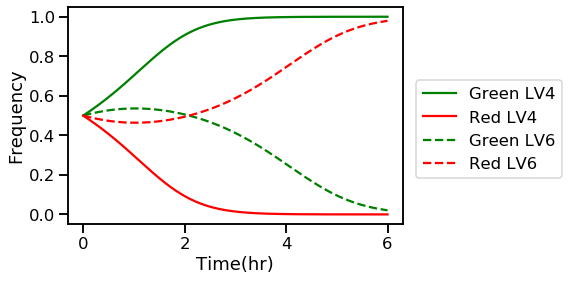

In [12]:
#did not use solve IVP

t = np.linspace(0,6,1000)
initial = np.array([50,50])

r1,r2 = 2,1.5 
k1,k2 = 1000,400
α1,α2 = 1,5

LV4_results = LV4(t,initial,r1,r2,k1,k2)
green4,red4 = LV4_results[:,0],LV4_results[:,1] 

LV6_results = LV6(t,initial,r1,r2,k1,k2,α1,α2)
green6,red6 = LV6_results[:,0],LV6_results[:,1] 

plt.plot(t,green4,linestyle='-',color='g',label='Green LV4')
plt.plot(t,red4  ,linestyle='-',color='r',label='Red LV4')

plt.plot(t,green6,linestyle='--',color='g',label='Green LV6')
plt.plot(t,red6  ,linestyle='--',color='r',label='Red LV6')

plt.xlabel('Time(hr)')
plt.ylabel('Frequency')

# plt.legend()
plt.legend(bbox_to_anchor=(1.5, 0.7))
plt.show()

**Fit both models to the data**.

You can use MLE or MCMC, what ever you prefer.

Think:
- what should be a good-enough loss function, and how you can minimize it?
- what should be the initial population sizes in `model`? 
- what should be the time points?

After fitting the two models, **print and plot a summary** of the fitting for each model:
- print the estimated parameters with some confidence interval,
- plot the data together with the fitted model.

Make sure the print messages and the plots are as clear and illustrative as possible.

<b>Answers:</b>

- I don't know what loos function will be ok, therefor, i tried 2 Loss functions , and showed it's converging to the "same Loss".
- the Initial popolation size, which u prb mean the frequency is based on our real data, at t=0.
- the time points shpuld be small eough to make sure the dt is small eough, but afterward we shpuld only look at the Daa points that we have information on. thus I used a pythonic mask to check only for the same time stamps. also, I had to use some rounding on order to make it sensible.

In [50]:
import scipy.optimize

t = np.round(np.linspace(0,6,61),1)
t_obs = np.round(df['time'].value_counts().index.values,1)
t_obs.sort()
mask = np.isin(t,t_obs)

green = df[df['strain']=='Green']['frequency'].values
red = df[df['strain']=='Red']['frequency'].values

def loss_(x0,green,red,t,ode): ### 
    x = model(ode,t,(0.5,0.5),*x0)
    mask = np.isin(t,t_obs)
    return 0.5 * (np.mean((x[:,0][mask] - green)**2) + np.mean((x[:,1][mask] - red)**2))

def loss2_(x0,green,red,t,ode): ### 
    x = model(ode,t,(0.5,0.5),*x0)
    mask = np.isin(t,t_obs)
    return 0.5 * (np.mean(np.abs(x[:,0][mask] - green)) + np.mean(np.abs(x[:,1][mask] - red)))

Note - tried those loss function but kept getting:  
Warning: Maximum number of function evaluations has been exceeded.  

Loss Mean Bias Error  
0.5 * (np.mean((x[0] - green)) + np.mean((x[1] - red)))  

Loss Cross Entropy  
0.5*np.sum((-x[0]*np.log(green) +(1-x[0])*np.log(green)) + (-x[1]*np.log(red) +(1-x[1])*np.log(red)))  

never the less, the parameters were quite the same.  

In [60]:
r1,r2,k1,k2,α1,α2 = 1.2,0.4,1,0.6,1.1,2.7

LV6_loss = scipy.optimize.fmin(
    loss_,                         
    x0 = (r1,r2,k1,k2,α1,α2),      
    args = (green,red,t,LV6_ode)   
)
print(LV6_loss)

LV6_loss = scipy.optimize.fmin(
    loss2_,                         
    x0 = (r1,r2,k1,k2,α1,α2),      
    args = (green,red,t,LV6_ode)   
)
print(LV6_loss)


Optimization terminated successfully.
         Current function value: 0.000799
         Iterations: 742
         Function evaluations: 1164
[ 0.65211135  0.42134597  1.14842675  0.61713642 -0.31624201  2.37666641]
Optimization terminated successfully.
         Current function value: 0.019443
         Iterations: 674
         Function evaluations: 1088
[1.57982102 0.22929529 1.36617879 0.65108655 0.42746426 2.86020783]


In [61]:
# r1,r2,k1,k2 = 0.5,1.7,0.6,0.8

LV4_loss = scipy.optimize.fmin(
    loss2_,                  # loss function to minimize
    x0 = (r1,r2,k1,k2),    #(1,2,2,2) , # guess
    args = (green,red,t,LV4_ode)   # arguments to loss function
)
print(LV4_loss)


Optimization terminated successfully.
         Current function value: 0.020796
         Iterations: 150
         Function evaluations: 259
[1.78986025 0.34710938 0.72278077 1.07599949]


In [62]:
print('result:')
print('LV6 loss:', loss2_(LV6_loss,green,red,t,LV6_ode))
print('r=',LV6_loss[0:2],'; k=',LV6_loss[2:4])

print('LV4 loss:',loss2_(LV4_loss,green,red,t,LV4_ode))
print('r=',LV4_loss[0:2],'; k=',LV4_loss[2:4])

# result:
# LV6 loss: XXXXXX
# r=XXXX, XXXX; K=XXXX, XXXX

# LV4 loss: XXXXXX
# r=XXXX, XXXX; K=XXXX, XXXX

result:
LV6 loss: 0.019443134213139993
r= [1.57982102 0.22929529] ; k= [1.36617879 0.65108655]
LV4 loss: 0.02079579331849105
r= [1.78986025 0.34710938] ; k= [0.72278077 1.07599949]


Since it may be difficult to decide which model is better based on the summaries and plots above, we perform model selection to select one of the models and answer the question:  _can the nested model LV4 be rejected in favor of the full model LV6?_

**Print and plot the steps to perform model selection**, and finish with a clear statement answering the question above.

Note: You can use the likelihood-ratio test or any other method; if you chose to perform Bayesian inference in the previous steps, you can use a measure such as AIC or WAIC.

Optimization terminated successfully.
         Current function value: 0.000799
         Iterations: 742
         Function evaluations: 1164
Optimization terminated successfully.
         Current function value: 0.020796
         Iterations: 150
         Function evaluations: 259


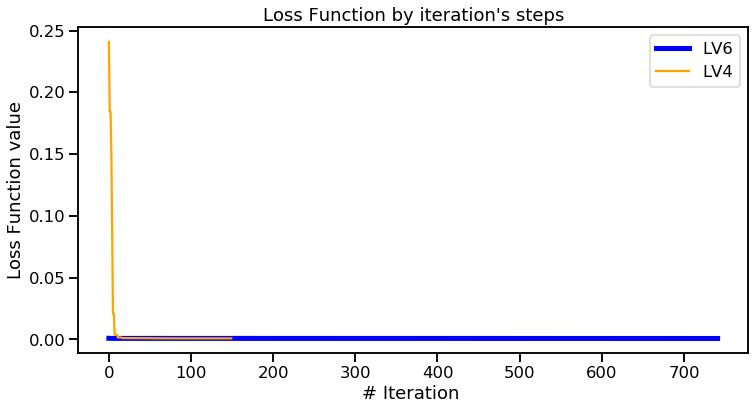

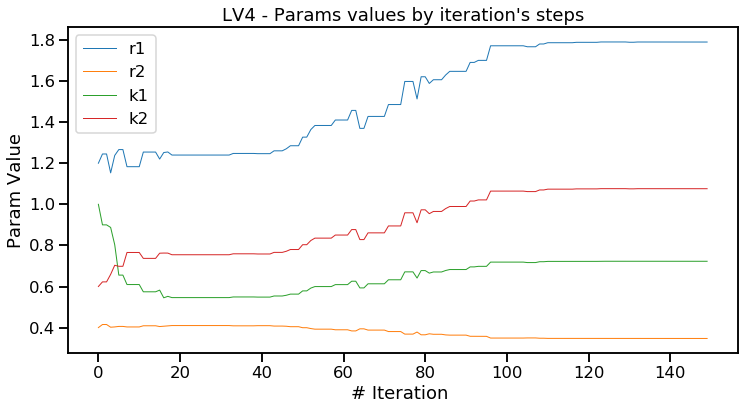

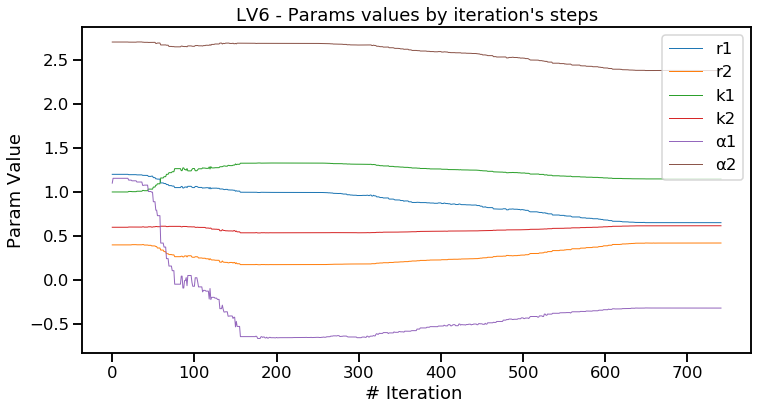

In [100]:
# r1,r2,k1,k2,α1,α2 = 0.5,1.7,0.6,0.8,1,2
r1,r2,k1,k2,α1,α2 = 1.2,0.4,1,0.6,1.1,2.7


params6, loss_value, num_iter, _, _, steps = scipy.optimize.fmin(
    loss_,                         
    x0 = (r1,r2,k1,k2,α1,α2),      
    args = (green,red,t,LV6_ode),
    full_output = True,
    retall = True
)
params6_steps = np.array(steps).T
x6_ = np.arange(num_iter)
y6_ = np.zeros(num_iter)

for i in x6_:
    y6_[i] = loss_(steps[i],green,red,t,LV6_ode)
    
params4, loss_value, num_iter, _, _, steps = scipy.optimize.fmin(
    loss2_,                  
    x0 = (r1,r2,k1,k2),    
    args = (green,red,t,LV4_ode),   
    full_output = True,
    retall = True

)
params4_steps = np.array(steps).T
x4_ = np.arange(num_iter)
y4_ = np.zeros(num_iter)

for i in x4_:
    y4_[i] = loss_(steps[i],green,red,t,LV4_ode)

plt.figure(figsize=(12,6))

plt.plot(x6_,y6_,linestyle='-',color='Blue',label='LV6',linewidth=5)
plt.plot(x4_,y4_,linestyle='-',color='Orange',label='LV4')

plt.xlabel('# Iteration ')
plt.ylabel('Loss Function value')
plt.title('Loss Function by iteration\'s steps')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))

plt.plot(params4_steps[0],label='r1',linewidth=1)
plt.plot(params4_steps[1],label='r2',linewidth=1)
plt.plot(params4_steps[2],label='k1',linewidth=1)
plt.plot(params4_steps[3],label='k2',linewidth=1)

plt.xlabel('# Iteration ')
plt.ylabel('Param Value')
plt.title('LV4 - Params values by iteration\'s steps')
plt.legend()
plt.show()


plt.figure(figsize=(12,6))

plt.plot(params6_steps[0],label='r1',linewidth=1)
plt.plot(params6_steps[1],label='r2',linewidth=1)
plt.plot(params6_steps[2],label='k1',linewidth=1)
plt.plot(params6_steps[3],label='k2',linewidth=1)
plt.plot(params6_steps[4],label='α1',linewidth=1)
plt.plot(params6_steps[5],label='α2',linewidth=1)


plt.xlabel('# Iteration ')
plt.ylabel('Param Value')
plt.title('LV6 - Params values by iteration\'s steps')
plt.legend()
plt.show()


In [101]:
# LK Ratio
N = np.array([green,red])
N_hat_LV4 = model(LV4_ode,t_obs,(green[0],red[0]),*params4 )
N_hat_LV6 = model(LV6_ode,t_obs,(green[0],red[0]),*params6 )

n = N.size                # data points number
p0 = 4                    # parameters in LV4 (null model)
p1 = 6                    # parameters in LV6 (alternative model)

rss0 = np.sum( (N.T-N_hat_LV4)**2 )
rss1 = np.sum( (N.T-N_hat_LV6)**2 )

F = ((rss0 - rss1) / (p1 - p0)) / (rss1 / (n - p1))  
pvalue = scipy.stats.f(p1 -p0, n - p1).sf(F)         # sf = 1-cdf

print("F-statistic: {:.2f}".format(F)) ###
print("Likelihood-ratio test P-value = {}".format(pvalue)) ###
print("LV6 model is favored?", pvalue < 0.05) ###

F-statistic: 4.00
Likelihood-ratio test P-value = 0.062476446509630815
LV6 model is favored? False


# Q: can the nested model LV4 be rejected in favor of the full model LV6?

<b> Answer: </b>  
Based on the F statistic & Pvalue I got - the answer is NO.  
Although, as we learned in class, I know that becuase LV4 is "contained" in LV6, I should rejent it in favor of LV6.  
Sadly, I did not find my mistake.  
Also, I can see that the difference is small, due the P value is almost reaching to 0.05%.  

**End of file**